# Demo for equiPy

## What its all about
A short demonstration on how to use _equipy_ on a set of real data.

Here, we use data derived from the US census using the [folktables](https://github.com/socialfoundations/folktables) package, freely available. Our goal is to render predictions of log income fair, with respect to demographic parity. 

We fit a very simple gradient boosting machine on the data and then compare:
* Fairness and performance of the optimal (unfair) predictor $f^*$ vs the fair estimator wrt. _race_
* Fairness and performance of $f^*$ vs the fair estimator wrt. _race_ **and** _gender_

## Prerequisits

This demo environment has the following packages installed:

1. equipy
2. lightgbm (for fitting)
3. folktables (to load the data set)
4. seaborn (for the kde plots)

Other dependencies should be covered in internal dependencies of _equipy_

You will also need to set your working directory below. 

## Suggestions and Comments

Feel free to share your thoughts and ideas to one of the authors 

In [ ]:
# Some manipulations for the illustration
import numpy as np
import pandas as pd

# For the basemodel
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# EquiPy
import equipy

import random
# Set the seed
random.seed(2023)
np.random.seed(2023)

In [4]:
#%load_ext autoreload 
#%autoreload 2
from utils.dataloader import load_sunbelt_data
from utils.preprocessing import preprocess_census
from utils.evaluation import cv_early_stopping

In [5]:
# Load some benchmarking data, can be replaced by any
# other data set
#
# Here we only load data for california, florida and texas
# all large states but with differing economies
data_all = load_sunbelt_data(states=['FL', 'TX', 'CA'])

In [6]:
cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

ret_dict =  preprocess_census(data=data_all,
                              target_feature='PINCP',
                              sensitive_features=['SEX', 'RAC1P_black'],
                              categorical_features=cat_features,
                              continuous_features=['WKHP', 'AGEP'])

In [7]:
params = {
    "objective": "regression",
    "metric": "mse",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "verbose": -1,
    "seed": 2023,
    "deterministic": True,
    "force_row_wise": True,
    "num_threads": 1,
    "device": "cpu"
}

In [8]:
%%capture
cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=ret_dict['X_train'], 
                               y_train=ret_dict['y_train'], 
                               categorical_feats=cat_features)

In [9]:
best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

Best MSE: 0.5461707285099612 
Best Iter: 384


In [10]:
# Retrain whole model
data_train_all = lgb.Dataset(data=ret_dict['X_train'], 
                             label=ret_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)

In [11]:
pred_calib = best_estimator.predict(ret_dict['X_calib'])
pred_calib_1 = pred_calib[np.where(ret_dict['X_calib'].RAC1P_black == 1)[0]]
pred_calib_2 = pred_calib[np.where(ret_dict['X_calib'].RAC1P_black == 0)[0]]

In [12]:
pred_test = best_estimator.predict(ret_dict['X_test'])
pred_test_1 = pred_test[np.where(ret_dict['X_test'].RAC1P_black == 1)[0]]
pred_test_2 = pred_test[np.where(ret_dict['X_test'].RAC1P_black == 0)[0]]

<Axes: ylabel='Density'>

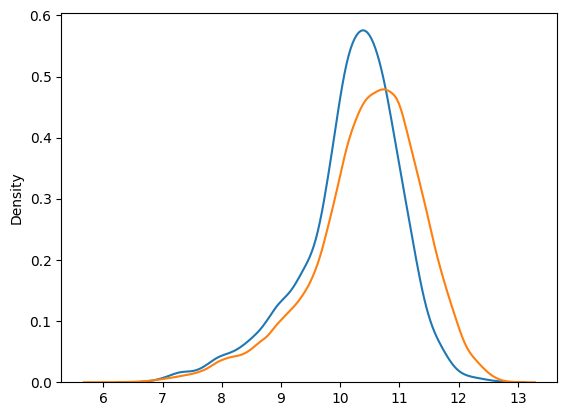

In [13]:
sns.kdeplot(pred_test_1)
sns.kdeplot(pred_test_2)

# Usage of Equipy for a Single Sensitive Attribute (SSA)

Here, we demonstrate how the _equipy_ package can be used to mitigate the unfairness in the predictions. 

In general, _equipy_ follows the logic of scikit-learn, where the mitigation method is a class that is first instantiated and then `fit()`-ted on training data to be used in the `tranform()` step on the test-set. 

See also the documentation for both 
* [FairWasserstein](https://equilibration.github.io/equipy/equipy.fairness.html#equipy.fairness.FairWasserstein)
* [unfairness](https://equilibration.github.io/equipy/equipy.metrics.html#equipy.metrics.unfairness)

In [15]:
from equipy.fairness import FairWasserstein
from equipy.metrics import unfairness, performance

In [16]:
sens_calib = pd.DataFrame({'ethnicity': np.where(ret_dict['X_calib'].RAC1P_black == 1, 1, 0)})
sens_test = pd.DataFrame({'ethnicity': np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0)})

In [18]:
print("Unfairness in the initial predictions: ", unfairness(pred_test, sens_test))
print("Performance in the initial predictions: ", performance(ret_dict['y_test'].values, pred_test))

Unfairness in the initial predictions:  0.43659617890670077
Performance in the initial predictions:  0.5443331062084942


In [19]:
calibrator = FairWasserstein(sigma=0.0001)
calibrator.fit(pred_calib, sens_calib)
fair_pred = calibrator.transform(pred_test, sens_test)

In [20]:
print("Unfairness in the fair predictions for Origin: ", unfairness(fair_pred, sens_test))
print("Performance in the fair predictions for Origin: ", performance(ret_dict['y_test'].values, fair_pred))

Unfairness in the fair predictions for Origin:  0.06737212281416305
Performance in the fair predictions for Origin:  0.5515244665463073


In [21]:
from equipy.graphs import fair_density_plot, fair_arrow_plot, fair_waterfall_plot, fair_multiple_arrow_plot

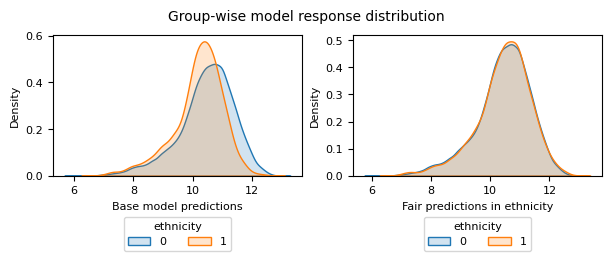

In [22]:
fair_density_plot(sens_calib, sens_test, pred_calib, pred_test,
                  figsize = (6,2.5))
plt.savefig("density_ssa.pdf")

(<Figure size 400x280 with 1 Axes>,
 <Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>)

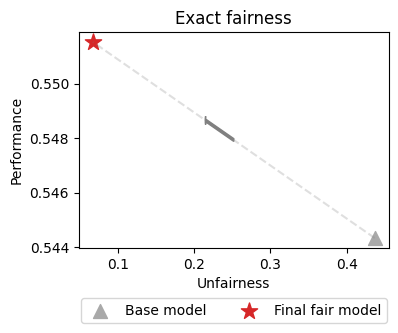

In [26]:
fair_arrow_plot(sens_calib, sens_test, pred_calib, pred_test, ret_dict['y_test'].values,
                figsize = (4,2.8))

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (exact) fairness'}, ylabel='Total unfairness'>)

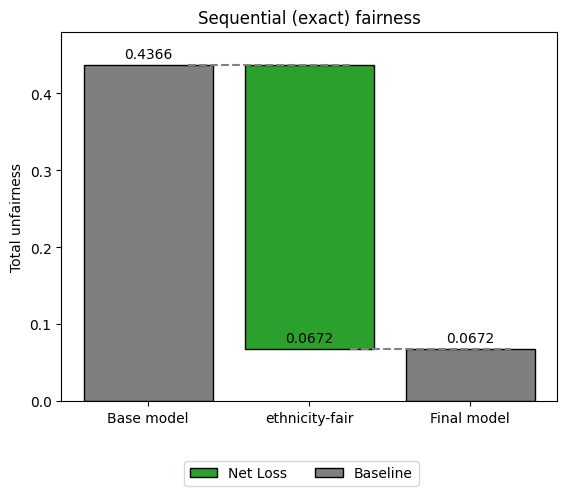

In [27]:
fair_waterfall_plot(sens_calib, sens_test, pred_calib, pred_test)

# Usage of Equipy for Multiple Sensitive Attributes (MSA)

Here, we demonstrate how the _equipy_ package can be used to mitigate the unfairness in the predictions. 

In general, _equipy_ follows the logic of scikit-learn, where the mitigation method is a class that is first instantiated and then `fit()`-ted on training data to be used in the `tranform()` step on the test-set. 

See also the documentation for both 
* [MultiWasserstein](https://equilibration.github.io/equipy/equipy.fairness.html#equipy.fairness.MultiWasserstein)
* [unfairness](https://equilibration.github.io/equipy/equipy.metrics.html#equipy.metrics.unfairness)

In [28]:
sens_twovar_calib = pd.DataFrame({
    'ethnicity': np.where(ret_dict['X_calib'].RAC1P_black == 1, 1, 0),
    'sex': np.where(ret_dict['X_calib'].SEX_2 == 1, 1, 0)
})

sens_twovar_test = pd.DataFrame({
    'ethnicity': np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0),
    'sex': np.where(ret_dict['X_test'].SEX_2 == 1, 1, 0)
})

In [29]:
print("Unfairness in the initial predictions: ", unfairness(pred_test, sens_twovar_test))
print("Performance in the initial predictions: ", performance(ret_dict['y_test'].values, pred_test))

Unfairness in the initial predictions:  0.7831159168905515
Performance in the initial predictions:  0.5443331062084942


In [30]:
from equipy.fairness import MultiWasserstein
calibrator_ssa = MultiWasserstein(sigma=0.0001)
calibrator_ssa.fit(pred_calib, sens_twovar_calib[['sex']])
fair_pred_ssa = calibrator_ssa.transform(pred_test, sens_twovar_test[['sex']])

In [31]:
print("Unfairness in sex for the initial predictions: ", unfairness(pred_test, sens_twovar_test[['sex']]))
print("Unfairness in ethnicity for the initial predictions: ", unfairness(pred_test, sens_twovar_test[['ethnicity']]))
print("Unfairness in sex for the fair predictions w.r.t. sex: ", unfairness(fair_pred_ssa, sens_twovar_test[['sex']]))
print("Unfairness in ethnicity for the fair predictions w.r.t. sex: ", unfairness(fair_pred_ssa, sens_twovar_test[['ethnicity']]))

Unfairness in sex for the initial predictions:  0.3465197379838507
Unfairness in ethnicity for the initial predictions:  0.43659617890670077
Unfairness in sex for the fair predictions w.r.t. sex:  0.03451317199817083
Unfairness in ethnicity for the fair predictions w.r.t. sex:  0.33435163663982514


In [32]:
from equipy.fairness import MultiWasserstein
calibrator_twovar = MultiWasserstein(sigma=0.0001)
calibrator_twovar.fit(pred_calib, sens_twovar_calib)
fair_pred_msa = calibrator_twovar.transform(pred_test, sens_twovar_test)

Since we consider multiple features, the initially fair predictions might not achieve the global fairness criteria in this case

In [33]:
print("Unfairness in the fair predictions for ethnicity and sex: ", unfairness(fair_pred_msa, sens_twovar_test))
print("Performance in the fair predictions for ethnicity and sex: ", performance(ret_dict['y_test'].values, fair_pred_msa))

Unfairness in the fair predictions for ethnicity and sex:  0.10640403044937052
Performance in the fair predictions for ethnicity and sex:  0.5881934244762622


In [34]:
# Calculate sequential unfairness
y_seq_fair = calibrator_twovar.y_fair
print(f"Unfairness before mitigation: {unfairness(y_seq_fair['Base model'], sens_twovar_test):.3f}")
print(f"Unfairness after mitigating biases from ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_twovar_test):.3f}")
print(f"Unfairness after mitigating biases from ethnicity and sex: {unfairness(y_seq_fair['sex'], sens_twovar_test):.3f}")

Unfairness before mitigation: 0.783
Unfairness after mitigating biases from ethnicity: 0.384
Unfairness after mitigating biases from ethnicity and sex: 0.106


In [55]:
# Calculate sequential unfairness in each sensitive variable
print(f"Unfairness in ethnicity before mitigation: {unfairness(y_seq_fair['Base model'], sens_twovar_test[['ethnicity']]):.4f}")
print(f"Unfairness in sex before mitigation: {unfairness(y_seq_fair['Base model'], sens_twovar_test[['sex']]):.4f}")
print(f"Unfairness in ethnicity and sex before mitigation: {unfairness(y_seq_fair['Base model'], sens_twovar_test):.4f}")

print(f"Unfairness in ethnicity after mitigation w.r.t. ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_twovar_test[['ethnicity']]):.4f}")
print(f"Unfairness in sex after mitigation w.r.t. ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_twovar_test[['sex']]):.4f}")
print(f"Unfairness in ethnicity and sex after mitigation w.r.t. ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_twovar_test):.4f}")

print(f"Unfairness in ethnicity after mitigation w.r.t. ethnicity and sex: {unfairness(y_seq_fair['sex'], sens_twovar_test[['ethnicity']]):.4f}")
print(f"Unfairness in sex after mitigation w.r.t. ethnicity and sex: {unfairness(y_seq_fair['sex'], sens_twovar_test[['sex']]):.4f}")
print(f"Unfairness in ethnicity and sex after mitigation w.r.t. ethnicity and sex: {unfairness(y_seq_fair['sex'], sens_twovar_test):.4f}")

Unfairness in ethnicity before mitigation: 0.4366
Unfairness in sex before mitigation: 0.3465
Unfairness in ethnicity and sex before mitigation: 0.7831
Unfairness in ethnicity after mitigation w.r.t. ethnicity: 0.0466
Unfairness in sex after mitigation w.r.t. ethnicity: 0.3376
Unfairness in ethnicity and sex after mitigation w.r.t. ethnicity: 0.3842
Unfairness in ethnicity after mitigation w.r.t. ethnicity and sex: 0.0726
Unfairness in sex after mitigation w.r.t. ethnicity and sex: 0.0338
Unfairness in ethnicity and sex after mitigation w.r.t. ethnicity and sex: 0.1064


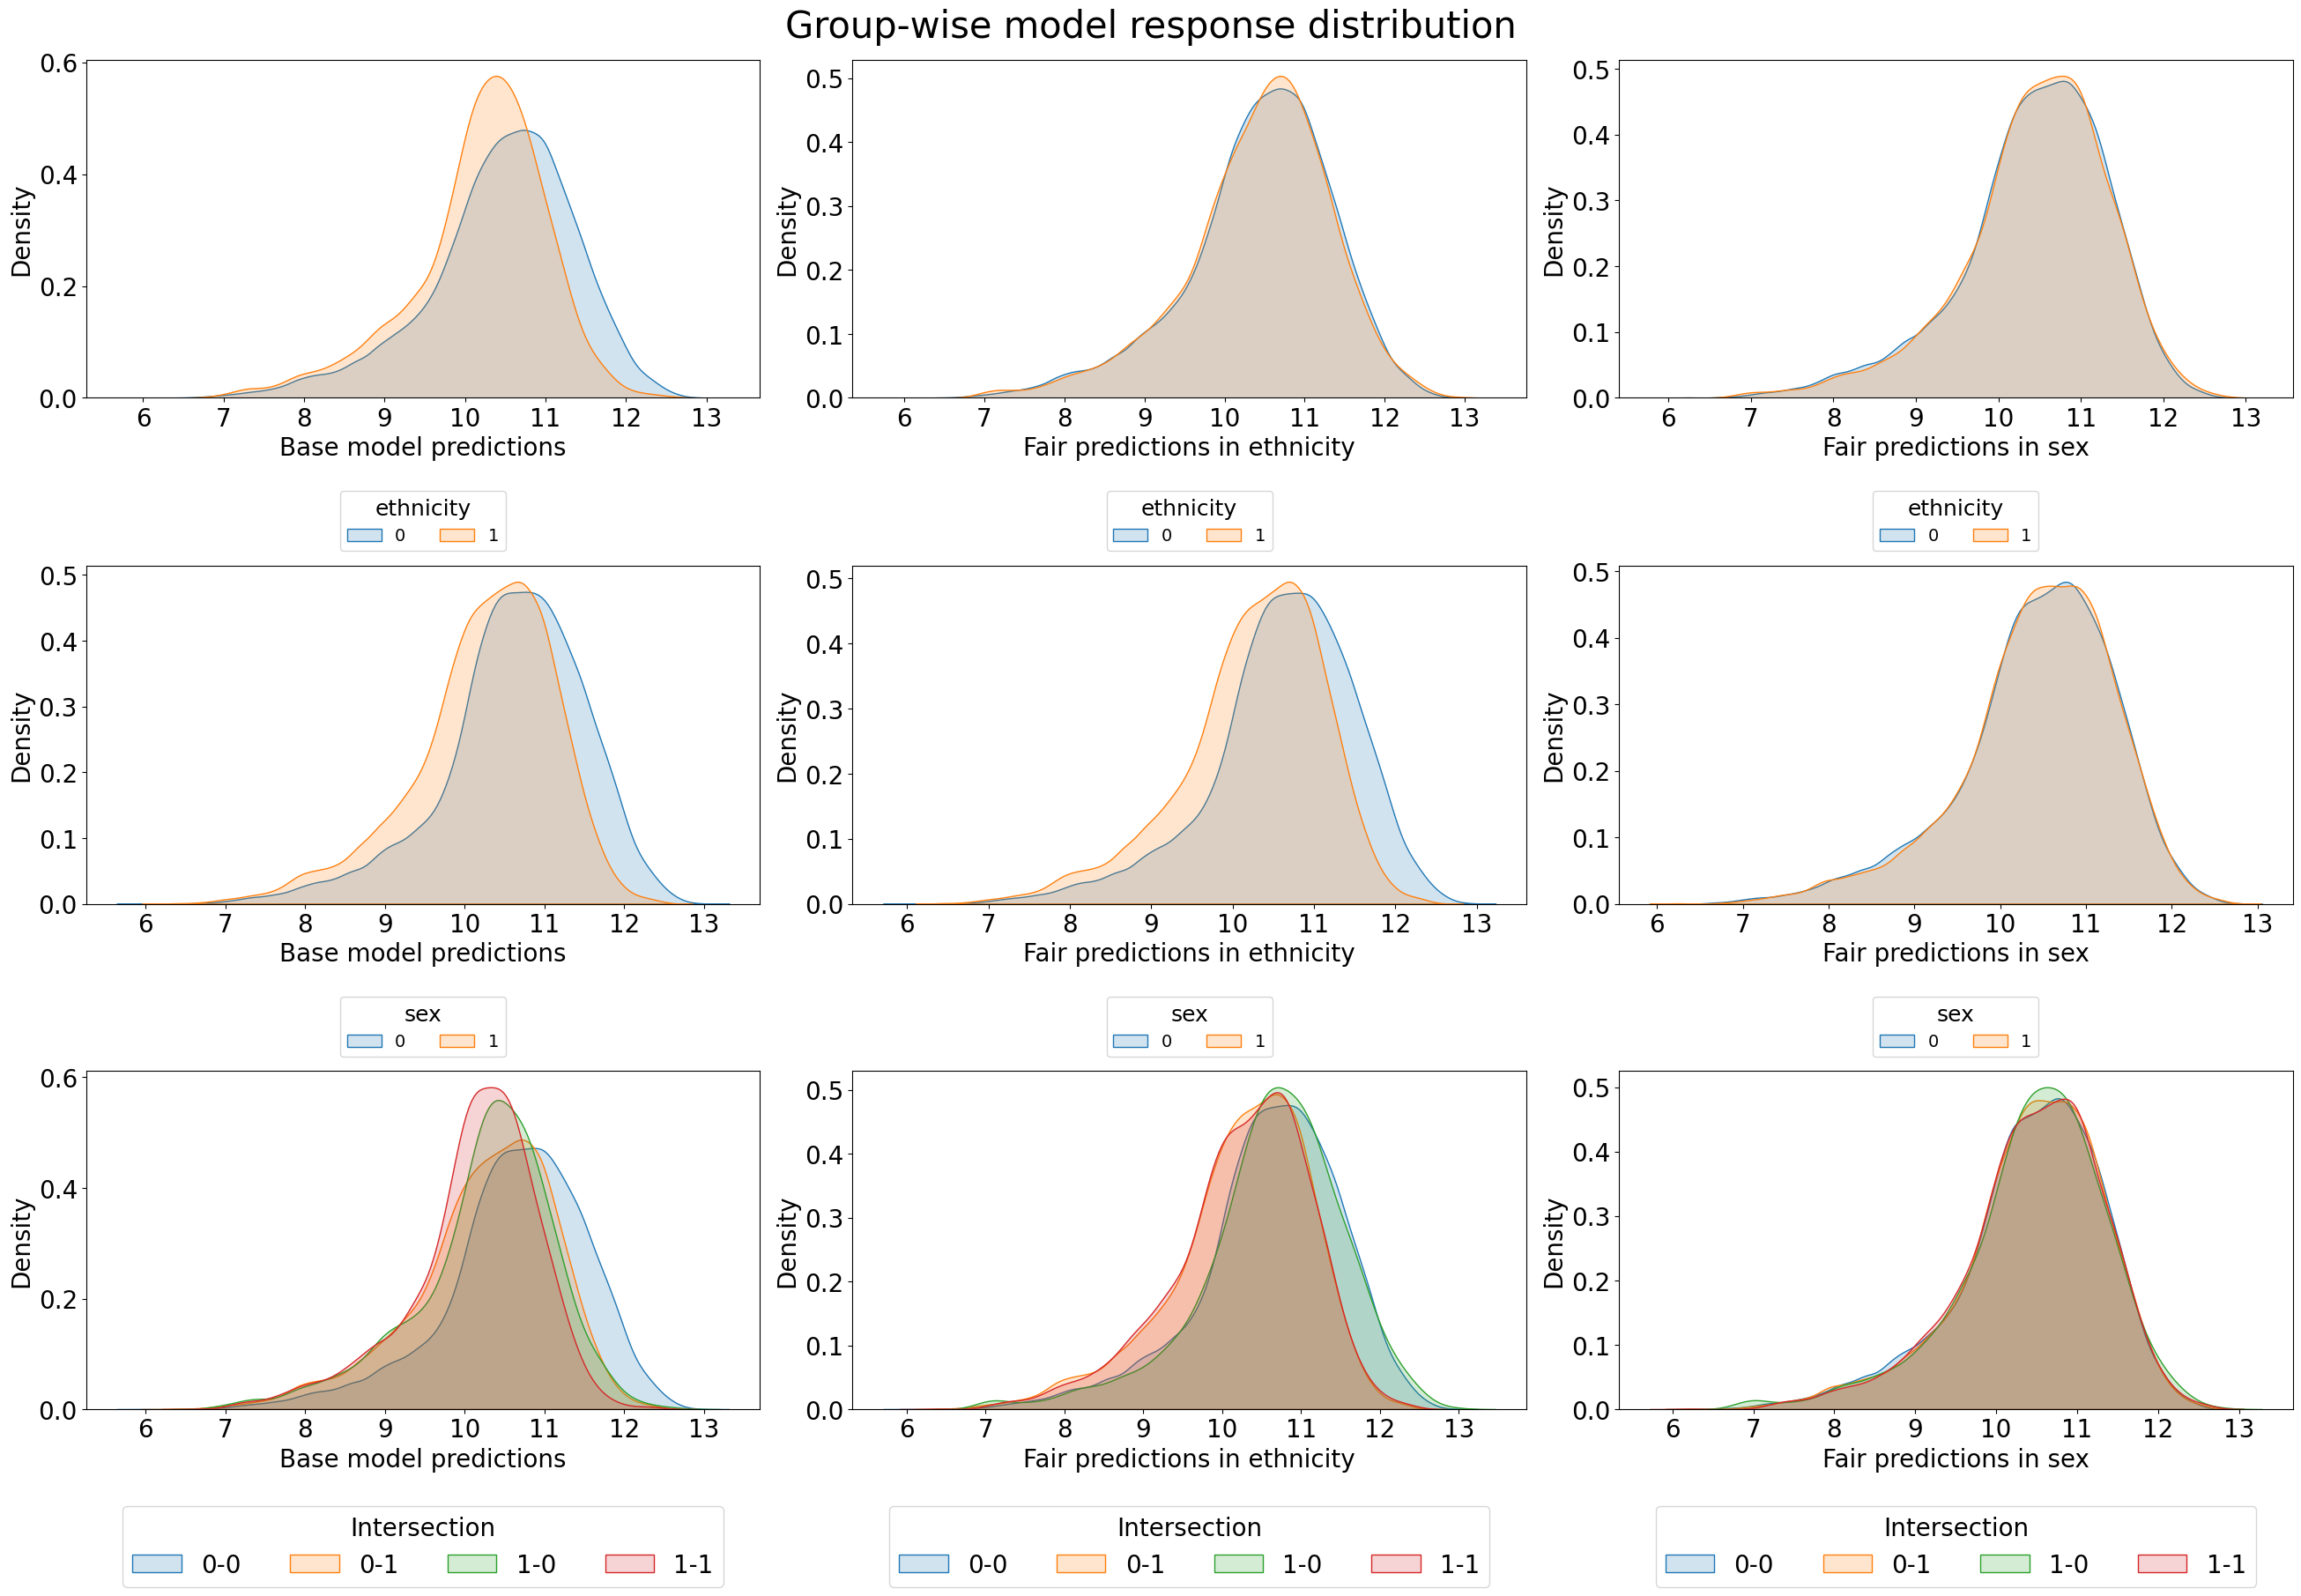

In [36]:
fair_density_plot(sens_twovar_calib,
                  sens_twovar_test,
                  pred_calib,
                  pred_test)
plt.savefig("density_msa.pdf")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>)

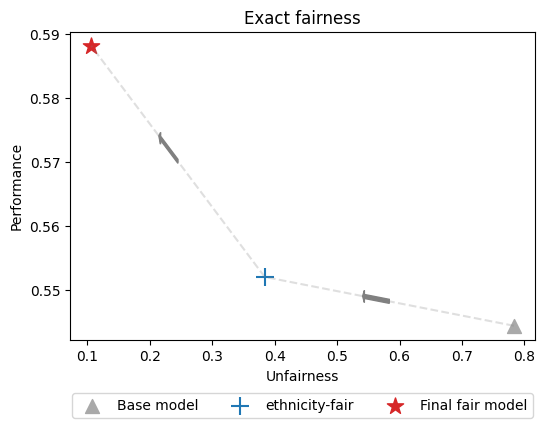

In [37]:
fair_arrow_plot(sens_twovar_calib, 
                sens_twovar_test, 
                pred_calib, 
                pred_test,
                ret_dict['y_test'].values,
                figsize = (6,4))

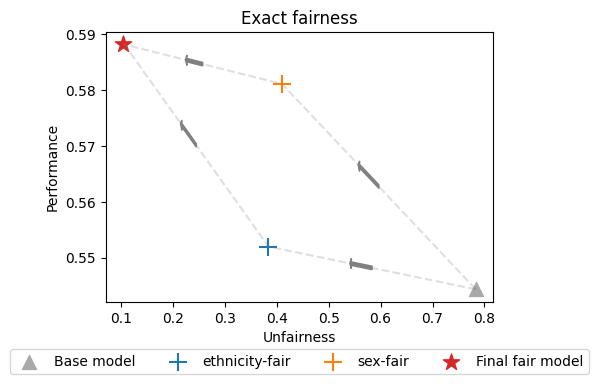

In [40]:
fair_multiple_arrow_plot(sens_twovar_calib, 
                sens_twovar_test, 
                pred_calib, 
                pred_test,
                ret_dict['y_test'].values,
                figsize = (5,3.5)
                )
plt.savefig("arrow_plot_msa.pdf", bbox_inches="tight")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (exact) fairness'}, ylabel='Total unfairness'>)

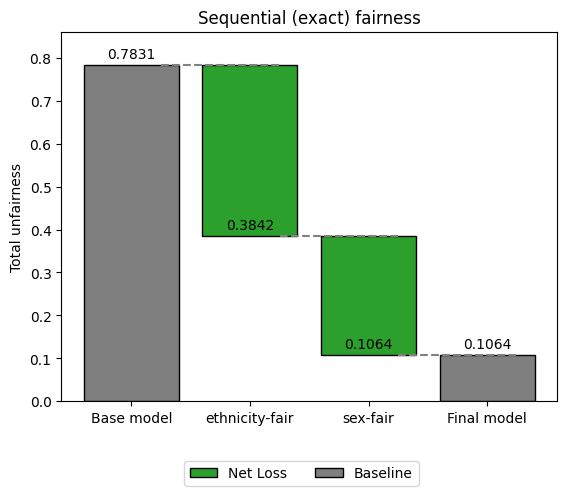

In [41]:
fair_waterfall_plot(sens_twovar_calib, 
                sens_twovar_test, 
                pred_calib, 
                pred_test
                )

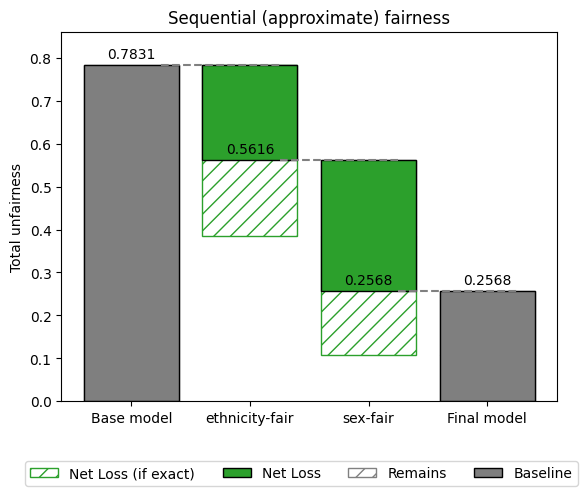

In [42]:
fair_waterfall_plot(sens_twovar_calib, 
                sens_twovar_test, 
                pred_calib, 
                pred_test,
                epsilon=[0.5, 0.25])
plt.savefig("waterfall_1.pdf")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>)

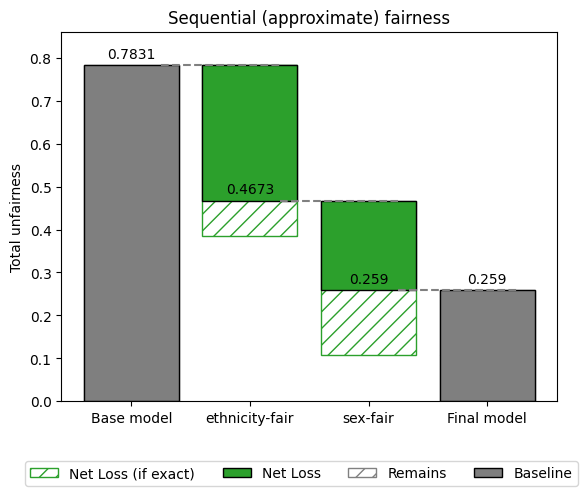

In [43]:
fair_waterfall_plot(sens_twovar_calib, 
                sens_twovar_test, 
                pred_calib, 
                pred_test,
                epsilon=[0.25, 0.5])

In [44]:
sens_twovar_order_calib = sens_twovar_calib[['sex', 'ethnicity']]
sens_twovar_order_test = sens_twovar_test[['sex', 'ethnicity']]

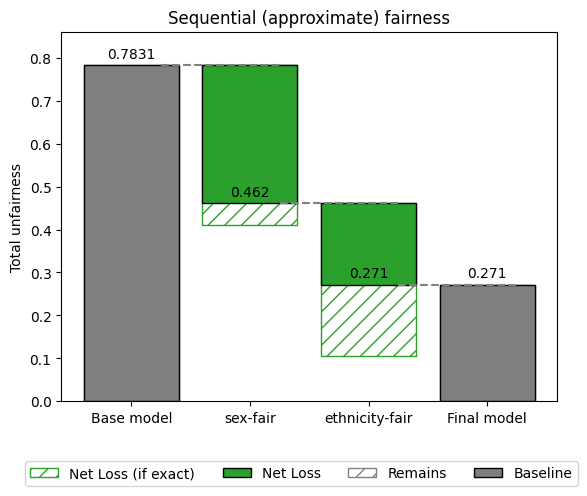

In [45]:
fair_waterfall_plot(sens_twovar_order_calib, 
                sens_twovar_order_test, 
                pred_calib, 
                pred_test,
                epsilon=[0.25, 0.5])
plt.savefig("waterfall_2.pdf")

## Check for intersectional fairness

In [46]:
# Create one sensitive attribute with 4 categories from A1 and A2
mapping = {
    (0, 0): '00',
    (0, 1): '01',
    (1, 0): '10',
    (1, 1): '11'
}

# Apply the mapping
int_sens_calib = sens_twovar_calib.apply(lambda row: mapping[(row['ethnicity'], row['sex'])], axis=1)
int_sens_test= sens_twovar_test.apply(lambda row: mapping[(row['ethnicity'], row['sex'])], axis=1)

int_sens_calib = pd.DataFrame(int_sens_calib, columns=['int'])
int_sens_test = pd.DataFrame(int_sens_test, columns=['int'])

In [47]:
calibrator_int = FairWasserstein(sigma=0.001)
calibrator_int.fit(pred_calib, int_sens_calib)
fair_pred_int = calibrator_int.transform(pred_test, int_sens_test)

In [48]:
unfairness(pred_test, int_sens_test), unfairness(fair_pred_int, int_sens_test)

(np.float64(0.5947117693614317), np.float64(0.22415620408531645))

In [49]:
calibrator_int = MultiWasserstein(sigma=0.0001)
calibrator_int.fit(pred_calib, int_sens_calib)
fair_pred_int = calibrator_int.transform(pred_test, int_sens_test)

In [50]:
unfairness(pred_test, int_sens_test), unfairness(fair_pred_int, int_sens_test)

(np.float64(0.5947117693614317), np.float64(0.22500593999976903))

(<Figure size 600x250 with 2 Axes>,
 array([<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in int', ylabel='Density'>],
       dtype=object))

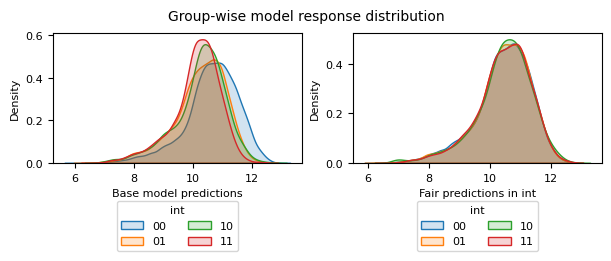

In [51]:
fair_density_plot(int_sens_calib,
                  int_sens_test,
                  pred_calib,
                  pred_test,
                  figsize = (6,2.5))